[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana6/1_ValuacionOpciones_Black_Scholes.ipynb)

# Valuación de Opciones

En esta sesión aprenderemos a utilizar una fórmula matemática, conocida como Black-Scholes, para dar un precio a nuestras opciones (tipo Call Europeo).

Una Call Europeo es un contrato en el cual se pacta comprar cierta cantidad de activos en el futuro, pero al precio que se encuentre actualmente.


Ejemplo:

Las acciones de Google cuestan \$100, yo veo que Google dice "Págame \$3 y en 30 días te vendo la acción a \$110" o "Págame \$5 y en 30 días te vendo la acción a \$100".

- Si no decido comprar el contrato no pasa nada.

- Si decido comprar el contrato hay dos posibilidades:
  - Si veo que en 30 días la acción cotiza a \$120, ejerzo el contrato y la compro a \$110
  - Si veo que en 30 días la acción cotiza a \$90, no ejerzo el contrato y mejor la compro directamente del mercado
  - Si en 30 días la acción sigue cotizando en \$100, ejercer el contrato o comprarla directamente da igual

El precio de una opción se modela como la solución de una ecuación diferencial parcial parabólica, que describe el precio de una opción en el tiempo: 

$$ \frac{\partial C}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 C}{\partial S^2} + rS\frac{\partial C}{\partial S} - rC = 0. $$

Donde $S$ es el precio del activo subyacente de la opción. El problema tiene las condiciones de frontera:

$$ 
C(0, t) = 0\text{ for all }t \\
C(S, t) \rightarrow S - K \text{ as }S \rightarrow \infty \\
C(S, T) = \max\{S - K, 0\}
$$


* La valuación también funciona para Put Europeo.

## Ejercicio 1:


¿Que interpretación tienen las condiciones de frontera? Piensenlo y comentenlo con la clase

## Ejercicio 2:
¿Porqué comprar Opciones en lugar de Activos? ¿Ventajas y desventajas?

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm

Los tickers a usar son:

- GOOGL: Acción de Google

- ^IRX: Treasury bills a 13 semanas

In [ ]:
data = yf.download(
        # Lista de tickers o puede ser un string
        tickers = "GOOGL ^IRX",

        # Parámetro "period", tambien se puede utilizar start/end
        # periodos válidos: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (opcional, default es '1mo')
        period = "1y",

        # Peidr datos por intervalo (incluye intradía si es menor a 60 days)
        # intervalos válidos: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (opcional, default es '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (opcional, default es 'column')
        # group_by = 'ticker',
    ).loc[:, 'Adj Close']
data

[*********************100%***********************]  2 of 2 completed


,GOOGL,^IRX
Date,,
2022-01-18 00:00:00-05:00,135.998001,0.130
2022-01-19 00:00:00-05:00,135.116501,0.165
2022-01-20 00:00:00-05:00,133.307495,0.168
2022-01-21 00:00:00-05:00,130.351501,0.158
2022-01-24 00:00:00-05:00,130.804001,0.155
...,...,...
2023-01-10 00:00:00-05:00,88.419998,4.565
2023-01-11 00:00:00-05:00,91.519997,4.555
2023-01-12 00:00:00-05:00,91.129997,4.475


In [ ]:
# Renombrar columna
data.rename(columns={'^IRX':'IRX'}, inplace=True)

In [ ]:
# Convertir un porcentaje a número
data['IRX'] = data['IRX']/100

In [ ]:
# Calculo de log-retornos
data['Vol. GOOGL'] = np.nan
data['log_ret'] = np.log(data['GOOGL']) - np.log(data['GOOGL'].shift(1))

In [ ]:
# Calculando la volatilidad de las acciones de GOOGLE
fechas_vol = data.index
for cada_fecha in fechas_vol[125:]:
    data_for_vol = fechas_vol[(cada_fecha - fechas_vol < pd.Timedelta(days=180)) & (cada_fecha - fechas_vol >= pd.Timedelta(days=0))] # 120 dias para 6 meses
    data.loc[cada_fecha, 'Vol. GOOGL'] = np.std(data['log_ret'][data_for_vol].values, ddof=1)*np.sqrt(252)


In [ ]:
# Nuestros nuevos datos
data

,GOOGL,IRX,Vol. GOOGL,log_ret
Date,,,,
2022-01-18 00:00:00-05:00,135.998001,0.00130,NaN,NaN
2022-01-19 00:00:00-05:00,135.116501,0.00165,NaN,-0.006503
2022-01-20 00:00:00-05:00,133.307495,0.00168,NaN,-0.013479
2022-01-21 00:00:00-05:00,130.351501,0.00158,NaN,-0.022424
2022-01-24 00:00:00-05:00,130.804001,0.00155,NaN,0.003465
...,...,...,...,...
2023-01-10 00:00:00-05:00,88.419998,0.04565,0.387426,0.004534
2023-01-11 00:00:00-05:00,91.519997,0.04555,0.390324,0.034459
2023-01-12 00:00:00-05:00,91.129997,0.04475,0.388766,-0.004270


In [ ]:
# Datos donde "Vol. GOOGL" deja de ser NULO
data[data['Vol. GOOGL'].notnull()]

,GOOGL,IRX,Vol. GOOGL,log_ret
Date,,,,
2022-07-19 00:00:00-04:00,113.809998,0.02450,0.392660,0.042907
2022-07-20 00:00:00-04:00,113.900002,0.02378,0.392286,0.000791
2022-07-21 00:00:00-04:00,114.339996,0.02360,0.391170,0.003856
2022-07-22 00:00:00-04:00,107.900002,0.02355,0.397882,-0.057972
2022-07-25 00:00:00-04:00,107.510002,0.02393,0.397344,-0.003621
...,...,...,...,...
2023-01-10 00:00:00-05:00,88.419998,0.04565,0.387426,0.004534
2023-01-11 00:00:00-05:00,91.519997,0.04555,0.390324,0.034459
2023-01-12 00:00:00-05:00,91.129997,0.04475,0.388766,-0.004270


Al resolver la ecuación diferencial se llega la siguiente formula, que permite valuar el Call (suponiendo que no paga dividendos):

\begin{align}
  C(S_t, t) &= N(d_1)S_t - N(d_2)Ke^{-r(T - t)} \\
     d_1 &= \frac{1}{\sigma\sqrt{T - t}}\left[\ln\left(\frac{S_t}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)(T - t)\right] \\
     d_2 &= d_1 - \sigma\sqrt{T - t}. \\
\end{align}

Donde:

\begin{align}
t &: \mbox{tiempo} \\
S_t &: \mbox{Precio del activo al tiempo }t \\
K &: \mbox{Precio acordado en el contrato} \\
r &: \mbox{Tasa libre de riesgo}\\
\sigma^2 &: \mbox{Volatilidad del activo subyacente} \\
N(\cdot) &: \mbox{Función de distribución de la normal (probabilidad acumulada)}
\end{align}

In [ ]:
def ByS_call(spot, strike, risk_free, vol, tiempo):
    d_1 = (np.log(spot/strike) + (risk_free + 0.5*vol*vol)*(tiempo/360)) / (vol * np.sqrt(tiempo/360))
    d_2 = d_1 - vol*np.sqrt(tiempo/360)
    value = spot * norm.cdf(d_1) - strike * np.exp(-risk_free * (tiempo/360)) * norm.cdf(d_2)
    return value

In [ ]:
un_dato = data.iloc[-1,:].copy()
un_dato

GOOGL         91.290001
IRX            0.044930
Vol. GOOGL     0.385682
log_ret       -0.009051
Name: 2023-01-17 00:00:00-05:00, dtype: float64

In [ ]:
# Strike es que tanto mas cara o mas barata me vendera la accion en el futuro
strike_agregado = 0

tiempo_madurez = 30

In [ ]:
un_dato.GOOGL

91.29000091552734

In [ ]:
ByS_call(un_dato.GOOGL, un_dato.GOOGL + 10, un_dato.IRX, un_dato['Vol. GOOGL'], tiempo_madurez)

1.07221743312655

In [ ]:
ByS_call(un_dato.GOOGL, un_dato.GOOGL + 0, un_dato.IRX, un_dato['Vol. GOOGL'], tiempo_madurez)

4.218026947607569

In [ ]:
ByS_call(un_dato.GOOGL, un_dato.GOOGL - 10, un_dato.IRX, un_dato['Vol. GOOGL'], tiempo_madurez)

10.992219830215518

# Ejercicio 3
¿Que significa la salida de la función "ByS_call()"?

El precio de la prima a pagar (el precio a pagarle a GOOGLE por firmar el contrato)

# Ejemplo de método apply()

Creamos una función "lambda" (una función temporal) para aplicar una función a todos los datos del DataFrame.

Abajo, susmamos 2 columnas para crear una nueva llamada "columna_extra"

In [ ]:
ejercicio = data.copy()
ejercicio

,GOOGL,IRX,Vol. GOOGL,log_ret
Date,,,,
2022-01-18 00:00:00-05:00,135.998001,0.00130,NaN,NaN
2022-01-19 00:00:00-05:00,135.116501,0.00165,NaN,-0.006503
2022-01-20 00:00:00-05:00,133.307495,0.00168,NaN,-0.013479
2022-01-21 00:00:00-05:00,130.351501,0.00158,NaN,-0.022424
2022-01-24 00:00:00-05:00,130.804001,0.00155,NaN,0.003465
...,...,...,...,...
2023-01-10 00:00:00-05:00,88.419998,0.04565,0.387426,0.004534
2023-01-11 00:00:00-05:00,91.519997,0.04555,0.390324,0.034459
2023-01-12 00:00:00-05:00,91.129997,0.04475,0.388766,-0.004270


In [ ]:
ejercicio.loc[:, 'columna_extra'] = data.apply(lambda x: x['GOOGL'] + x['Vol. GOOGL'], axis=1)
ejercicio

,GOOGL,IRX,Vol. GOOGL,log_ret,columna_extra
Date,,,,,
2022-01-18 00:00:00-05:00,135.998001,0.00130,NaN,NaN,NaN
2022-01-19 00:00:00-05:00,135.116501,0.00165,NaN,-0.006503,NaN
2022-01-20 00:00:00-05:00,133.307495,0.00168,NaN,-0.013479,NaN
2022-01-21 00:00:00-05:00,130.351501,0.00158,NaN,-0.022424,NaN
2022-01-24 00:00:00-05:00,130.804001,0.00155,NaN,0.003465,NaN
...,...,...,...,...,...
2023-01-10 00:00:00-05:00,88.419998,0.04565,0.387426,0.004534,88.807424
2023-01-11 00:00:00-05:00,91.519997,0.04555,0.390324,0.034459,91.910321
2023-01-12 00:00:00-05:00,91.129997,0.04475,0.388766,-0.004270,91.518763


## Otro modo de usar el método apply() al tener

In [ ]:
def func_duplicar(x1):
  return x1 + x1

In [ ]:
coso = data[['GOOGL']].copy()
coso

,GOOGL
Date,
2022-01-18 00:00:00-05:00,135.998001
2022-01-19 00:00:00-05:00,135.116501
2022-01-20 00:00:00-05:00,133.307495
2022-01-21 00:00:00-05:00,130.351501
2022-01-24 00:00:00-05:00,130.804001
...,...
2023-01-10 00:00:00-05:00,88.419998
2023-01-11 00:00:00-05:00,91.519997
2023-01-12 00:00:00-05:00,91.129997


In [ ]:
ejercicio.loc[:, 'col_extra'] = coso.apply(func_duplicar)

In [ ]:
ejercicio

,GOOGL,IRX,Vol. GOOGL,log_ret,columna_extra,col_extra
Date,,,,,,
2022-01-18 00:00:00-05:00,135.998001,0.00130,NaN,NaN,NaN,271.996002
2022-01-19 00:00:00-05:00,135.116501,0.00165,NaN,-0.006503,NaN,270.233002
2022-01-20 00:00:00-05:00,133.307495,0.00168,NaN,-0.013479,NaN,266.614990
2022-01-21 00:00:00-05:00,130.351501,0.00158,NaN,-0.022424,NaN,260.703003
2022-01-24 00:00:00-05:00,130.804001,0.00155,NaN,0.003465,NaN,261.608002
...,...,...,...,...,...,...
2023-01-10 00:00:00-05:00,88.419998,0.04565,0.387426,0.004534,88.807424,176.839996
2023-01-11 00:00:00-05:00,91.519997,0.04555,0.390324,0.034459,91.910321,183.039993
2023-01-12 00:00:00-05:00,91.129997,0.04475,0.388766,-0.004270,91.518763,182.259995


## Ejercicio 4

Quiten las columnas 'columna_extra' y 'col_extra' del DataFrame "ejercicio" y después agreguen una columna con nombre "precio_de_calls" que tenga el precio del call en cada fila del DataFrame.

In [ ]:
# Espacio para ejercicio
ejercicio = ejercicio[ejercicio['Vol. GOOGL'].notnull()]
ejercicio

ejercicio.drop(columns=['columna_extra', 'col_extra'], inplace=True)


In [ ]:
ejercicio['precio_de_calls'] = ejercicio.apply(lambda x: ByS_call(x['GOOGL'], x['GOOGL'] + 10, x['IRX'], x['Vol. GOOGL'], 30), axis=1)

In [ ]:
ejercicio

,GOOGL,IRX,Vol. GOOGL,log_ret,precio_de_calls
Date,,,,,
2022-07-19 00:00:00-04:00,113.809998,0.02450,0.392660,0.042907,1.838929
2022-07-20 00:00:00-04:00,113.900002,0.02378,0.392286,0.000791,1.836565
2022-07-21 00:00:00-04:00,114.339996,0.02360,0.391170,0.003856,1.839874
2022-07-22 00:00:00-04:00,107.900002,0.02355,0.397882,-0.057972,1.682595
2022-07-25 00:00:00-04:00,107.510002,0.02393,0.397344,-0.003621,1.664568
...,...,...,...,...,...
2023-01-10 00:00:00-05:00,88.419998,0.04565,0.387426,0.004534,0.999625
2023-01-11 00:00:00-05:00,91.519997,0.04555,0.390324,0.034459,1.114574
2023-01-12 00:00:00-05:00,91.129997,0.04475,0.388766,-0.004270,1.089823


## Ejercicio 5

Visualice algún histograma de los precios de las opciones tipo Call Europeo

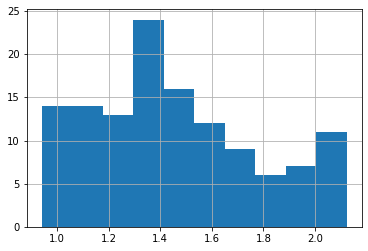

In [ ]:
# Espacio para ejercicio

ejercicio.precio_de_calls.hist()

Por último, solo ver como avanza el precio de los calls.

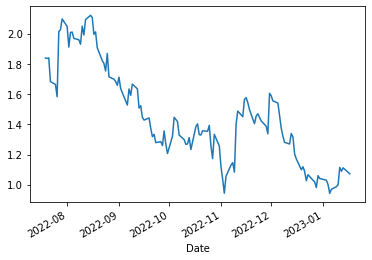

In [ ]:
ejercicio.precio_de_calls.plot()

In [ ]:
import matplotlib.pyplot as plt

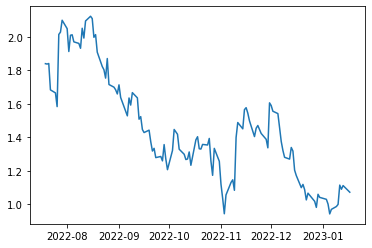

In [ ]:
# Se puede graficar utilizando directamente la función del módulo "Matplotlib"
plt.plot(ejercicio.precio_de_calls)